In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import (
    roc_auc_score, precision_score, recall_score, 
    f1_score, confusion_matrix, classification_report, roc_curve
)
import smote_variants as sv
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import scipy.stats as stats

In [2]:
data = pd.read_csv('creditcard.csv')

In [3]:
scaler_amount = RobustScaler()
scaler_time = StandardScaler()
data['Amount'] = scaler_amount.fit_transform(data['Amount'].values.reshape(-1, 1))
data['Time'] = scaler_time.fit_transform(data['Time'].values.reshape(-1, 1))
data = data.sample(frac=1, random_state=1)

In [4]:
X = data.drop('Class', axis=1).values
y = data['Class'].values

In [5]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=0)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=0)

array([[<Axes: title={'center': 'Time'}>, <Axes: title={'center': 'V1'}>,
        <Axes: title={'center': 'V2'}>, <Axes: title={'center': 'V3'}>,
        <Axes: title={'center': 'V4'}>, <Axes: title={'center': 'V5'}>],
       [<Axes: title={'center': 'V6'}>, <Axes: title={'center': 'V7'}>,
        <Axes: title={'center': 'V8'}>, <Axes: title={'center': 'V9'}>,
        <Axes: title={'center': 'V10'}>, <Axes: title={'center': 'V11'}>],
       [<Axes: title={'center': 'V12'}>, <Axes: title={'center': 'V13'}>,
        <Axes: title={'center': 'V14'}>, <Axes: title={'center': 'V15'}>,
        <Axes: title={'center': 'V16'}>, <Axes: title={'center': 'V17'}>],
       [<Axes: title={'center': 'V18'}>, <Axes: title={'center': 'V19'}>,
        <Axes: title={'center': 'V20'}>, <Axes: title={'center': 'V21'}>,
        <Axes: title={'center': 'V22'}>, <Axes: title={'center': 'V23'}>],
       [<Axes: title={'center': 'V24'}>, <Axes: title={'center': 'V25'}>,
        <Axes: title={'center': 'V26'}>, <

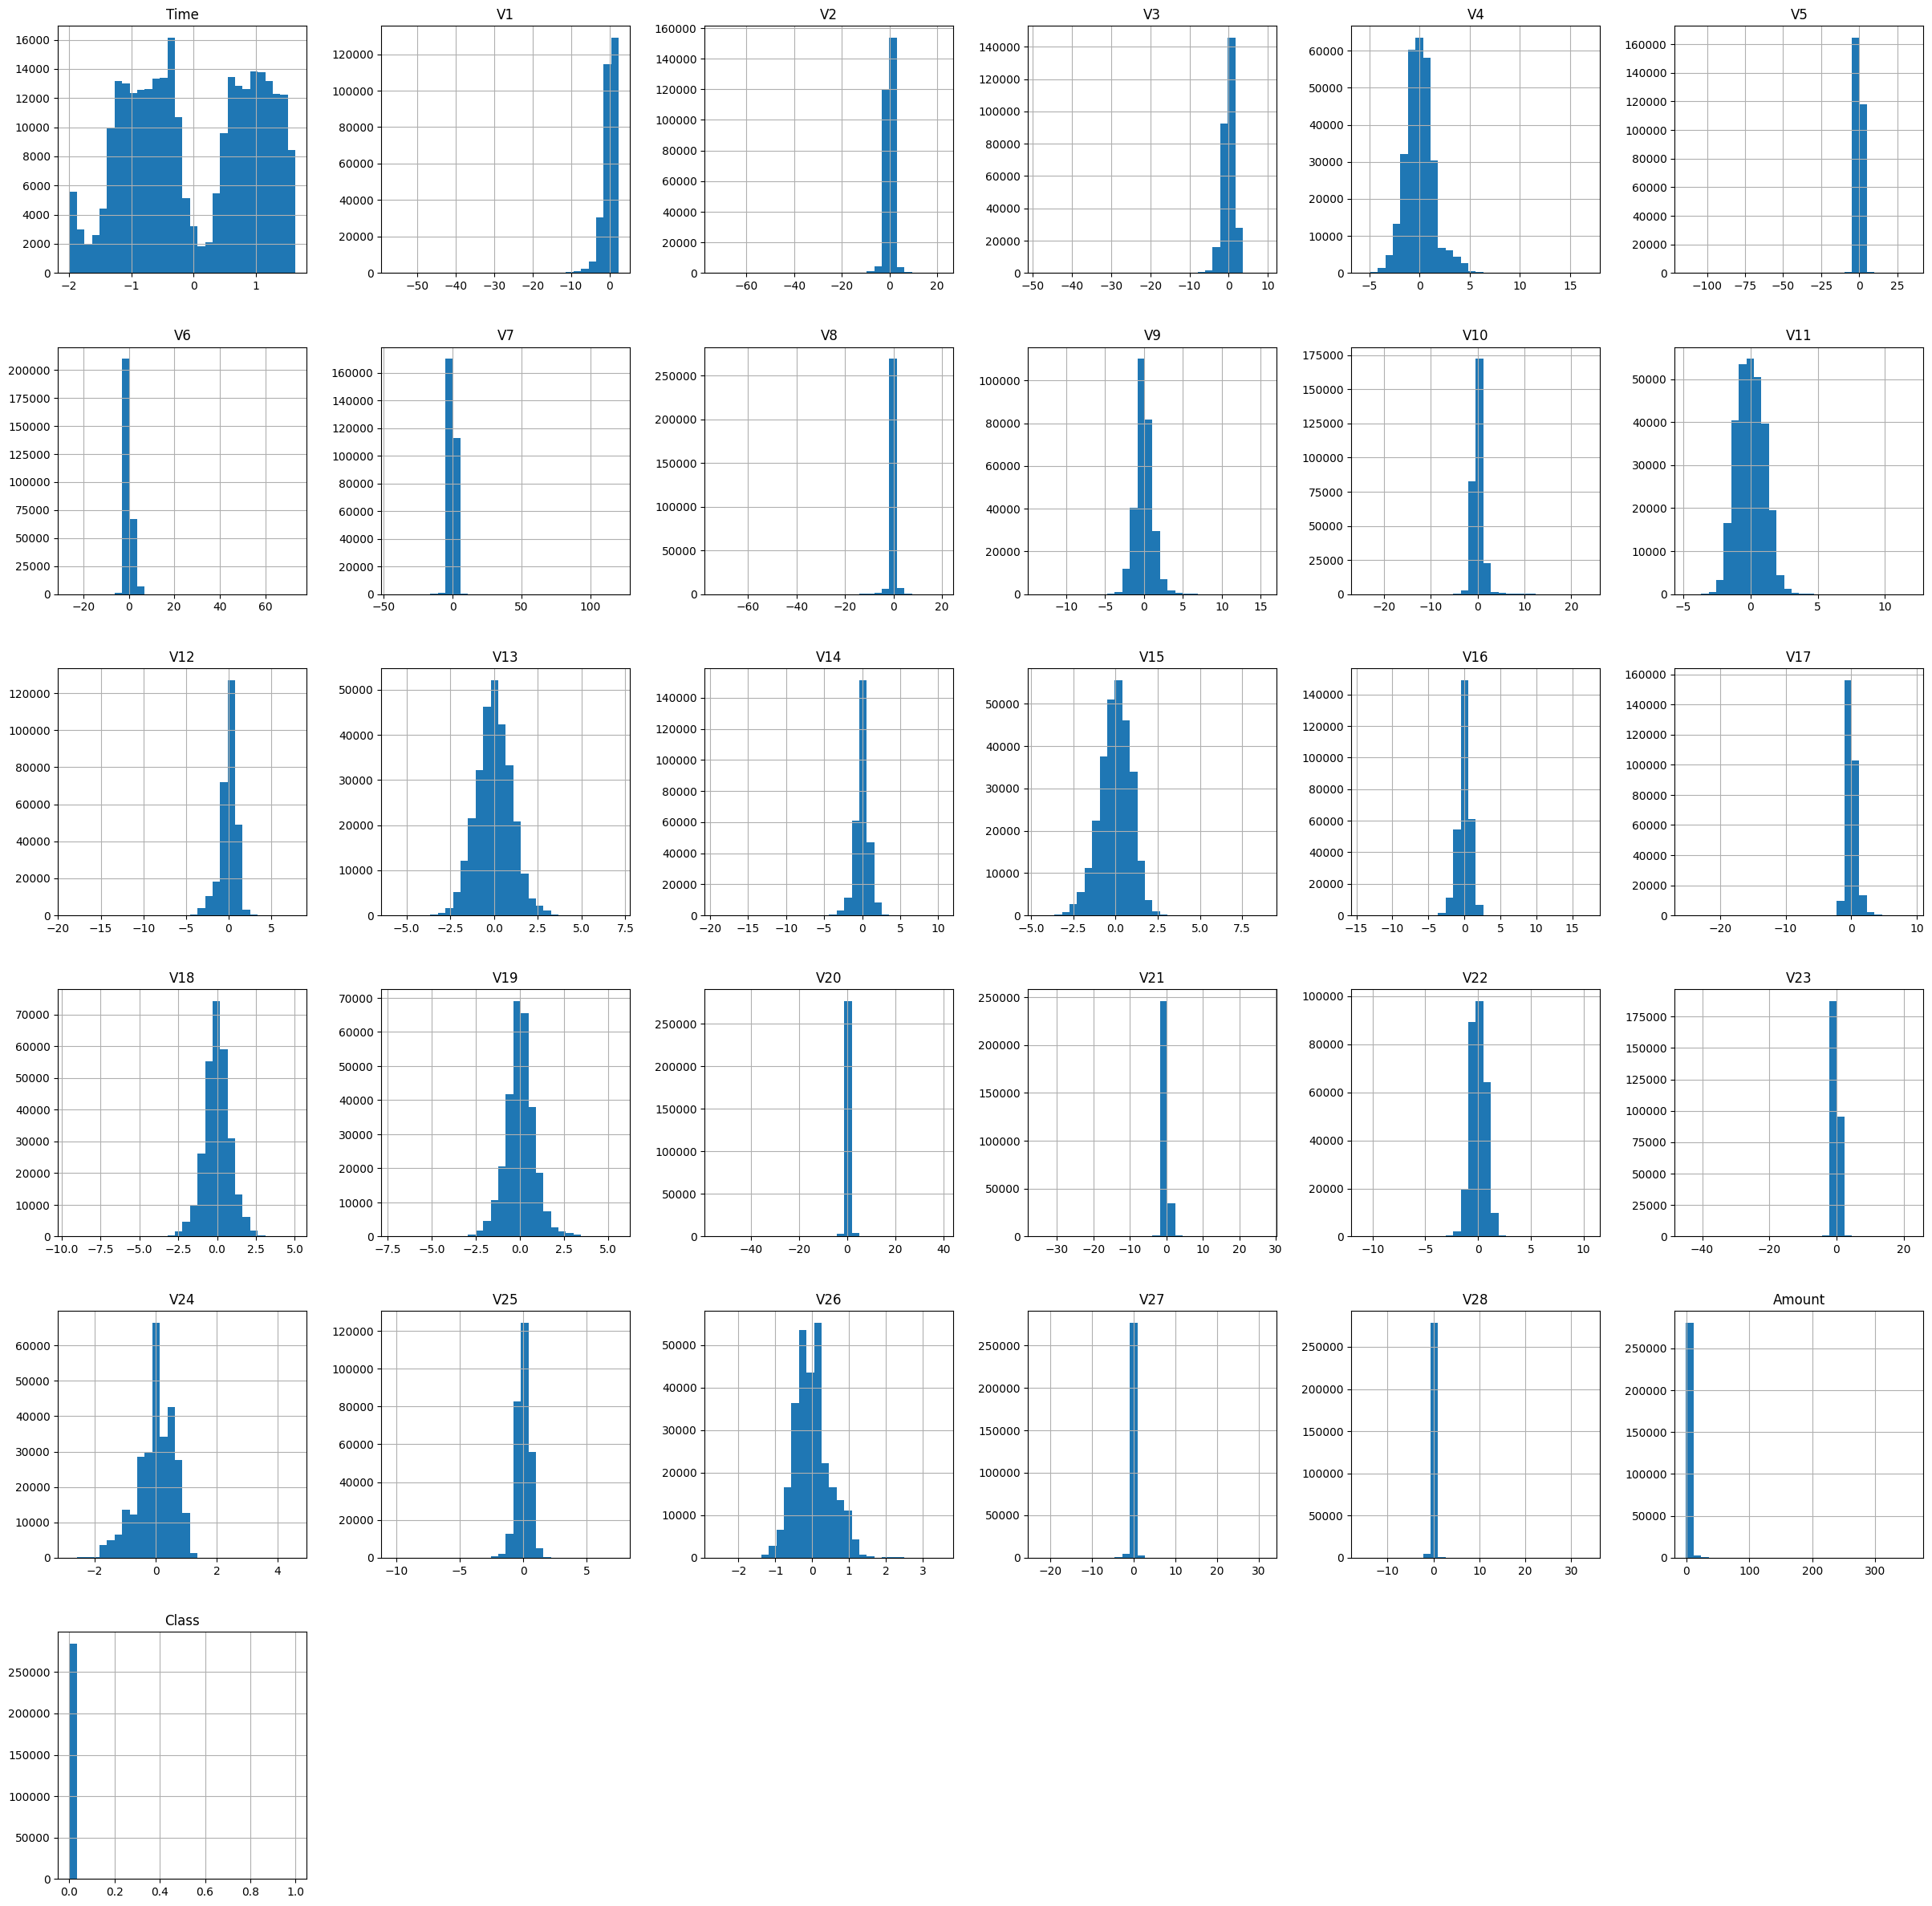

In [23]:
data.hist(bins=30, figsize=(30,30))

<Axes: >

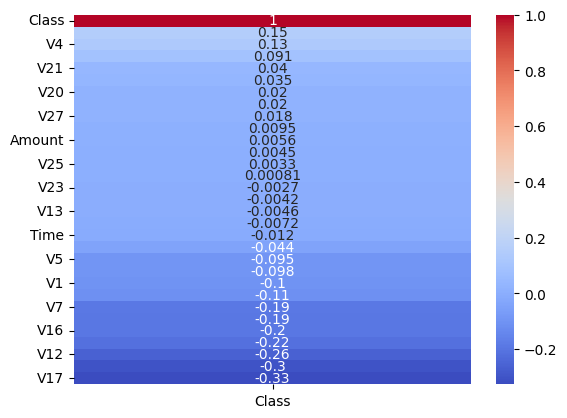

In [6]:
corr_matrix = data.corr()['Class'].sort_values(ascending=False).to_frame()
sns.heatmap(corr_matrix,cmap='coolwarm',annot=True)


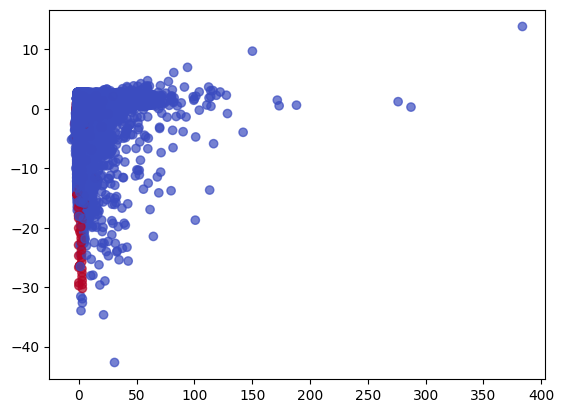

In [7]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X)
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=y, cmap='coolwarm', alpha=0.7)
plt.show()

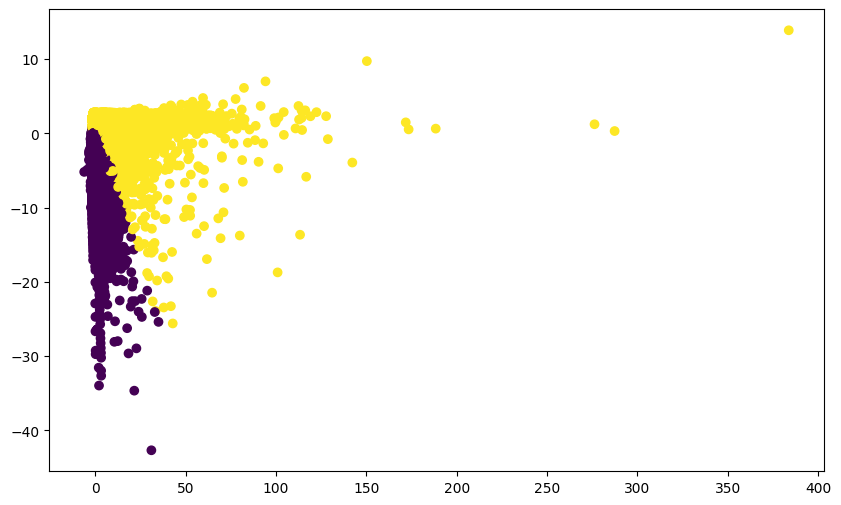

In [8]:
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(X)
plt.figure(figsize=(10, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=clusters, cmap='viridis')
plt.show()

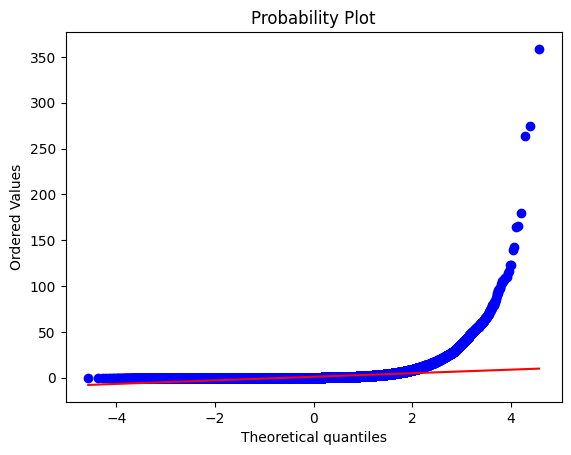

In [9]:
stats.probplot(data['Amount'], dist="norm", plot=plt)
plt.show()

In [10]:
def evaluate_model(model, X, y):
    y_pred = model.predict(X)
    y_prob = model.predict_proba(X)[:, 1] if hasattr(model, 'predict_proba') else model.predict(X)
    return {
        'ROC AUC': roc_auc_score(y, y_prob),
        'Precision': precision_score(y, y_pred),
        'Recall': recall_score(y, y_pred),
        'F1 Score': f1_score(y, y_pred),
        'Confusion Matrix': confusion_matrix(y, y_pred)
    }

In [11]:
classifiers = [
    LogisticRegression(max_iter=1000),
    # RandomForestClassifier(),
    # GradientBoostingClassifier(),
    # SVC(probability=True),
    XGBClassifier()
]


In [12]:
augmentation_methods = ['polynom_fit_SMOTE_mesh']
results_before_aug = {}
results_after_aug = {}


In [13]:
for clf in classifiers:
    clf_name = clf.__class__.__name__
    clf.fit(X_train, y_train)
    results_before_aug[clf_name] = evaluate_model(clf, X_val, y_val)

In [14]:
for method in augmentation_methods:
    print(f"Applying {method} augmentation...")

    oversampler_class = getattr(sv, method)
    oversampler = oversampler_class()

    X_aug, y_aug = oversampler.sample(X_train, y_train)
    print(f"Original X_train shape: {X_train.shape}, Augmented X shape: {X_aug.shape}")

    aug_results = {}
    for clf in classifiers:
        clf_name = clf.__class__.__name__
        print(f"Training {clf_name} on augmented data...")
        clf.fit(X_aug, y_aug)
        aug_results[clf_name] = evaluate_model(clf, X_val, y_val)

    results_after_aug[method] = aug_results


2024-10-28 12:13:25,526:INFO:polynom_fit_SMOTE_mesh: Running sampling via ('polynom_fit_SMOTE_mesh', "{'proportion': 1.0, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'deterministic', 'gaussian_component': {}}, 'random_state': None, 'class_name': 'polynom_fit_SMOTE_mesh'}")
2024-10-28 12:13:25,549:INFO:polynom_fit_SMOTE_mesh: simplex sampling with n_dim 2


Applying polynom_fit_SMOTE_mesh augmentation...
Original X_train shape: (199364, 30), Augmented X shape: (398050, 30)
Training LogisticRegression on augmented data...
Training XGBClassifier on augmented data...


In [15]:
print("Comparison of models before augmentation:")
for clf_name, metrics in results_before_aug.items():
    print(f"\nClassifier: {clf_name}")
    for metric, value in metrics.items():
        print(f"{metric}: {value}")
    print("-" * 50)

Comparison of models before augmentation:

Classifier: LogisticRegression
ROC AUC: 0.9846262685818075
Precision: 0.9206349206349206
Recall: 0.7532467532467533
F1 Score: 0.8285714285714286
Confusion Matrix: [[42639     5]
 [   19    58]]
--------------------------------------------------

Classifier: XGBClassifier
ROC AUC: 0.9836288840134633
Precision: 0.9253731343283582
Recall: 0.8051948051948052
F1 Score: 0.8611111111111112
Confusion Matrix: [[42639     5]
 [   15    62]]
--------------------------------------------------


In [16]:
if results_after_aug:
    for method, models in results_after_aug.items():
        print(f"\nResults for augmentation method: {method}")
        for clf_name, metrics in models.items():
            print(f"\nClassifier: {clf_name}")
            for metric, value in metrics.items():
                print(f"{metric}: {value}")
            print("-" * 50)
else:
    print("No results available after augmentation.")


Results for augmentation method: polynom_fit_SMOTE_mesh

Classifier: LogisticRegression
ROC AUC: 0.9798762816772385
Precision: 0.20833333333333334
Recall: 0.9090909090909091
F1 Score: 0.3389830508474576
Confusion Matrix: [[42378   266]
 [    7    70]]
--------------------------------------------------

Classifier: XGBClassifier
ROC AUC: 0.9875329974406046
Precision: 0.6767676767676768
Recall: 0.8701298701298701
F1 Score: 0.7613636363636364
Confusion Matrix: [[42612    32]
 [   10    67]]
--------------------------------------------------


In [19]:
def create_neural_network(input_shape):
    model = Sequential([
        InputLayer(shape=(input_shape,)),
        Dense(16, activation='relu'),
        BatchNormalization(),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [21]:
neural_network = create_neural_network(X_train.shape[1])
checkpoint = ModelCheckpoint('best_nn_model.keras', save_best_only=True)

neural_network.fit(
    X_train, y_train, validation_data=(X_val, y_val), 
    epochs=10, batch_size=64, callbacks=[checkpoint]
)

y_prob = neural_network.predict(X_val)

y_pred = (y_prob > 0.5).astype(int)

nn_metrics = {
    'ROC AUC': roc_auc_score(y_val, y_prob),
    'Precision': precision_score(y_val, y_pred),
    'Recall': recall_score(y_val, y_pred),
    'F1 Score': f1_score(y_val, y_pred),
    'Confusion Matrix': confusion_matrix(y_val, y_pred)
}

print("\nNeural Network Results:")
for metric, value in nn_metrics.items():
    print(f"{metric}: {value}")
print("-" * 50)

Epoch 1/10
3116/3116 ━━━━━━━━━━━━━━━━━━━━ 3s 781us/step - accuracy: 0.9522 - loss: 0.1710 - val_accuracy: 0.9992 - val_loss: 0.0056
Epoch 2/10
3116/3116 ━━━━━━━━━━━━━━━━━━━━ 2s 691us/step - accuracy: 0.9992 - loss: 0.0035 - val_accuracy: 0.9986 - val_loss: 0.0086
Epoch 3/10
3116/3116 ━━━━━━━━━━━━━━━━━━━━ 2s 720us/step - accuracy: 0.9994 - loss: 0.0027 - val_accuracy: 0.9995 - val_loss: 0.0049
Epoch 4/10
3116/3116 ━━━━━━━━━━━━━━━━━━━━ 2s 786us/step - accuracy: 0.9994 - loss: 0.0025 - val_accuracy: 0.9992 - val_loss: 0.0050
Epoch 5/10
3116/3116 ━━━━━━━━━━━━━━━━━━━━ 3s 805us/step - accuracy: 0.9994 - loss: 0.0026 - val_accuracy: 0.9995 - val_loss: 0.0052
Epoch 6/10
3116/3116 ━━━━━━━━━━━━━━━━━━━━ 3s 793us/step - accuracy: 0.9994 - loss: 0.0027 - val_accuracy: 0.9995 - val_loss: 0.0051
Epoch 7/10
3116/3116 ━━━━━━━━━━━━━━━━━━━━ 3s 796us/step - accuracy: 0.9994 - loss: 0.0025 - val_accuracy: 0.9995 - val_loss: 0.0052
Epoch 8/10
3116/3116 ━━━━━━━━━━━━━━━━━━━━ 3s 808us/step - accuracy: 0.9995 -

In [22]:
for method in augmentation_methods:
    print(f"Applying {method} augmentation to neural network...")

    oversampler_class = getattr(sv, method)
    oversampler = oversampler_class()
    X_aug, y_aug = oversampler.sample(X_train, y_train)
    print(f"Original X_train shape: {X_train.shape}, Augmented X shape: {X_aug.shape}")

    neural_network = create_neural_network(X_aug.shape[1])
    checkpoint = ModelCheckpoint('best_nn_model.keras', save_best_only=True)

    neural_network.fit(
        X_aug, y_aug, validation_data=(X_val, y_val),
        epochs=10, batch_size=64, callbacks=[checkpoint]
    )

    y_prob = neural_network.predict(X_val)

    y_pred = (y_prob > 0.5).astype(int)

    nn_metrics = {
        'ROC AUC': roc_auc_score(y_val, y_prob),
        'Precision': precision_score(y_val, y_pred),
        'Recall': recall_score(y_val, y_pred),
        'F1 Score': f1_score(y_val, y_pred),
        'Confusion Matrix': confusion_matrix(y_val, y_pred)
    }

    print(f"\nNeural Network Results with {method} Augmentation:")
    for metric, value in nn_metrics.items():
        print(f"{metric}: {value}")
    print("-" * 50)

2024-10-28 12:17:25,154:INFO:polynom_fit_SMOTE_mesh: Running sampling via ('polynom_fit_SMOTE_mesh', "{'proportion': 1.0, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'deterministic', 'gaussian_component': {}}, 'random_state': None, 'class_name': 'polynom_fit_SMOTE_mesh'}")
2024-10-28 12:17:25,172:INFO:polynom_fit_SMOTE_mesh: simplex sampling with n_dim 2


Applying polynom_fit_SMOTE_mesh augmentation to neural network...
Original X_train shape: (199364, 30), Augmented X shape: (398050, 30)
Epoch 1/10
6220/6220 ━━━━━━━━━━━━━━━━━━━━ 5s 670us/step - accuracy: 0.9661 - loss: 0.0924 - val_accuracy: 0.9980 - val_loss: 0.0092
Epoch 2/10
6220/6220 ━━━━━━━━━━━━━━━━━━━━ 4s 649us/step - accuracy: 0.9962 - loss: 0.0116 - val_accuracy: 0.9977 - val_loss: 0.0094
Epoch 3/10
6220/6220 ━━━━━━━━━━━━━━━━━━━━ 4s 644us/step - accuracy: 0.9974 - loss: 0.0080 - val_accuracy: 0.9978 - val_loss: 0.0098
Epoch 4/10
6220/6220 ━━━━━━━━━━━━━━━━━━━━ 4s 628us/step - accuracy: 0.9979 - loss: 0.0068 - val_accuracy: 0.9984 - val_loss: 0.0079
Epoch 5/10
6220/6220 ━━━━━━━━━━━━━━━━━━━━ 4s 634us/step - accuracy: 0.9979 - loss: 0.0070 - val_accuracy: 0.9984 - val_loss: 0.0082
Epoch 6/10
6220/6220 ━━━━━━━━━━━━━━━━━━━━ 4s 629us/step - accuracy: 0.9981 - loss: 0.0067 - val_accuracy: 0.9978 - val_loss: 0.0099
Epoch 7/10
6220/6220 ━━━━━━━━━━━━━━━━━━━━ 4s 653us/step - accuracy: 0.99

In [ ]:
param_grids = {
    'LogisticRegression': {
        'C': [0.01, 0.1, 1, 10, 100],  
        'solver': ['lbfgs', 'liblinear']
    },
    'XGBClassifier': {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2]
    },
    'RandomForestClassifier': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30]
    },
    'GradientBoostingClassifier': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    },
    'SVC': {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf']
    }
}

grid_search_results = {}

for clf in classifiers:
    clf_name = clf.__class__.__name__
    
    if clf_name not in param_grids:
        print(f"No parameter grid found for {clf_name}, skipping...")
        continue

    print(f"Performing Grid Search for {clf_name}...")

    param_grid = param_grids[clf_name]

    grid_search = GridSearchCV(
        estimator=clf, param_grid=param_grid, 
        cv=3, scoring='roc_auc', n_jobs=-1
    )

    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    metrics = evaluate_model(best_model, X_val, y_val)

    grid_search_results[clf_name] = metrics

    print(f"\n{clf_name} with GridSearch Results:")
    for metric, value in metrics.items():
        print(f"{metric}: {value}")
    print("-" * 50)
